# ML-7. Прогнозирование биологического ответа (HW-3)

Необходимо обучить две модели: `логистическую регрессию` и `случайный лес`. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. 

> Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [9]:
# скачать данные
!wget https://lms-cdn.skillfactory.ru/assets/courseware/v1/9f2add5bca59f8c4df927432d605fff3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_train_sem09__1_.zip

In [10]:
import numpy as np
import pandas as pd

from sklearn import linear_model #линейные моделиё
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials
import optuna

import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

import warnings
warnings.filterwarnings('ignore')


In [11]:
data = pd.read_csv('_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [13]:
random_state = 42
max_iter = 50

# Разделяем выборку на тренировочную и тестовую в соотношении 80/20.
# Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state, test_size=0.2)

## Логистическая регрессия

In [14]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter=max_iter)

#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))

y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


В этом разделе подберем гиперпараметры для модели логистической регрессии c помощью следующих методов:

### 1. GridSeachCV

In [15]:
param_grid = [
    {
        'penalty': ['l2', 'none'] ,  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    },
]

grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=max_iter,
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
)

%time grid_search_lr.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_lr.score(X_test, y_test)))

y_test_pred = grid_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn

CPU times: user 2.29 s, sys: 240 ms, total: 2.53 s
Wall time: 24 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


### Выводы
* метод GridSeachCV помог улучшить $F_1$ метрику с 0.78 до 0.79

### 2. RandomizedSearchCV

In [16]:
param_distribution = [
    {
        'penalty': ['l2', 'none'] ,
        'solver': ['lbfgs', 'sag'],
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    }
]

random_search_lr = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=max_iter,
    ),
    param_distributions=param_distribution,
    n_iter=max_iter,
    cv=5,
    n_jobs=-1,
)

%time random_search_lr.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search_lr.score(X_test, y_test)))

y_test_pred = random_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))


/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

CPU times: user 2.84 s, sys: 879 ms, total: 3.72 s
Wall time: 20.4 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.3}


### Выводы
* метод RandomizedSearchCV помог улучшить $F_1$ метрику с 0.78 до 0.79
* нет улучшения метрики по сравнению с методом GridSeachCV, но скорость работы лучше (22.6 сек) по сравнению с методом GridSeachCV(24.1 сек)

### 3. Hyperopt

In [17]:
penalty_list = ['l1', 'l2']
solver_list = ['liblinear', 'saga']
space = {
    'penalty': hp.choice('penalty', penalty_list),
    'solver': hp.choice('solver', solver_list),
    'C': hp.uniform('C', 0.01, 1),
}

def hyperopt_lr(params, X=X_train, y=y_train, cv=5, random_state=random_state):
    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state,
        max_iter=max_iter,
    )

    # обучаем модель
    model.fit(X, y)

    score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [18]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_lr, # наша функция
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=max_iter, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [00:33<00:00,  1.48trial/s, best loss: -0.8935395814376705]
Наилучшие значения гиперпараметров {'C': 0.9985710176440787, 'penalty': 1, 'solver': 0}
CPU times: user 51.6 s, sys: 1min 31s, total: 2min 23s
Wall time: 33.7 s


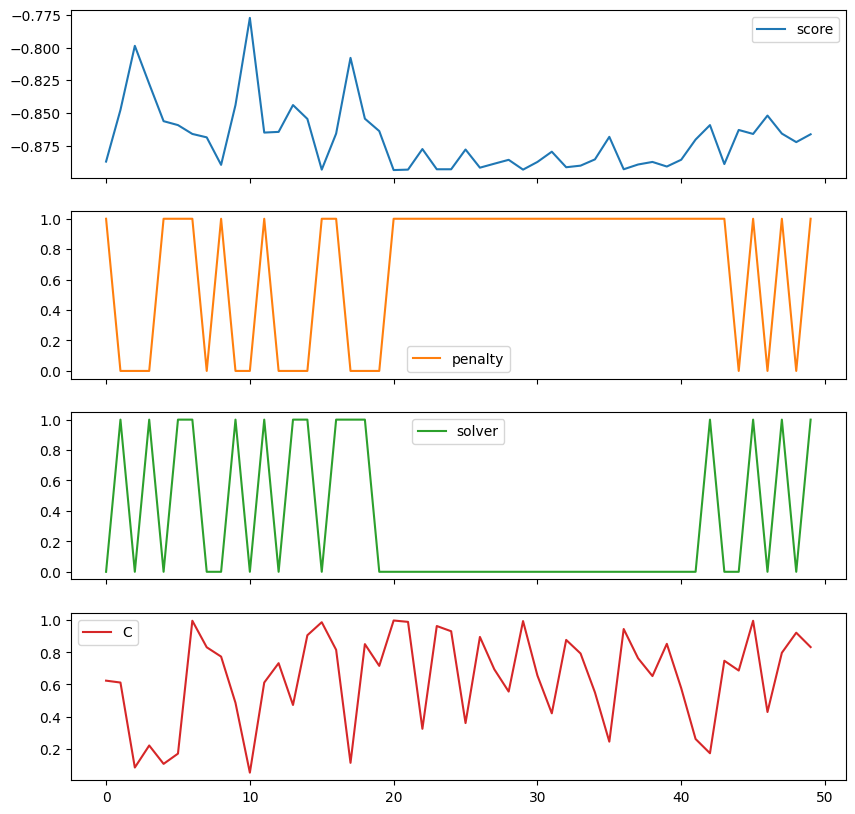

In [19]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'solver', 'C'])
tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [20]:
# расчитаем точность на тестовой выборке и полученных выше гиперпараметров

hyperopt_lr = linear_model.LogisticRegression(
    penalty=penalty_list[best['penalty']],
    solver=solver_list[best['solver']],
    C=best['C'],
    random_state=random_state,
    max_iter=max_iter,
)

hyperopt_lr.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(hyperopt_lr.score(X_test, y_test)))

y_test_pred = hyperopt_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


#### Промежуточные выводы:
* метод Hyperpot показал худший результат ($F_1 = 0.78$) по сравнению с базовыми методами ($F_1 = 0.79$)
* интересно, что точность только ухудшалась при количестве итераций больше 10

In [21]:
%%time

# поиск гиперпараметров с помощью кросс-валидации

def hyperopt_lr_with_cv(params, X=X_train, y=y_train, cv=5, random_state=random_state):
    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state,
        max_iter=max_iter,
    )

    # обучаем модель
    model.fit(X, y)

    # обучение с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_lr_with_cv, # наша функция
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=max_iter, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

  4%|▍         | 2/50 [00:04<01:58,  2.48s/trial, best loss: -0.7841071594645037]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

  8%|▊         | 4/50 [00:07<01:38,  2.15s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 12%|█▏        | 6/50 [00:10<01:19,  1.81s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 14%|█▍        | 7/50 [00:13<01:24,  1.97s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 20%|██        | 10/50 [00:17<01:18,  1.97s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 24%|██▍       | 12/50 [00:20<01:05,  1.71s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 28%|██▊       | 14/50 [00:24<01:14,  2.07s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 30%|███       | 15/50 [00:28<01:33,  2.67s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 34%|███▍      | 17/50 [00:31<01:11,  2.15s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 36%|███▌      | 18/50 [00:34<01:17,  2.41s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 38%|███▊      | 19/50 [00:38<01:29,  2.89s/trial, best loss: -0.7904516202991784]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 42%|████▏     | 21/50 [00:43<01:14,  2.57s/trial, best loss: -0.7917979236699126]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 44%|████▍     | 22/50 [00:46<01:18,  2.79s/trial, best loss: -0.7917979236699126]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 46%|████▌     | 23/50 [00:49<01:19,  2.95s/trial, best loss: -0.7917979236699126]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 48%|████▊     | 24/50 [00:52<01:19,  3.05s/trial, best loss: -0.7917979236699126]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 50%|█████     | 25/50 [00:56<01:18,  3.13s/trial, best loss: -0.7917979236699126]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 52%|█████▏    | 26/50 [00:59<01:15,  3.16s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 54%|█████▍    | 27/50 [01:02<01:12,  3.16s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 56%|█████▌    | 28/50 [01:06<01:11,  3.24s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 58%|█████▊    | 29/50 [01:09<01:10,  3.36s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 60%|██████    | 30/50 [01:12<01:06,  3.31s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 62%|██████▏   | 31/50 [01:16<01:03,  3.34s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 64%|██████▍   | 32/50 [01:19<00:59,  3.29s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 68%|██████▊   | 34/50 [01:24<00:46,  2.89s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 70%|███████   | 35/50 [01:26<00:40,  2.72s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 72%|███████▏  | 36/50 [01:29<00:39,  2.83s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 76%|███████▌  | 38/50 [01:32<00:27,  2.28s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 78%|███████▊  | 39/50 [01:35<00:27,  2.51s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 82%|████████▏ | 41/50 [01:39<00:19,  2.21s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 86%|████████▌ | 43/50 [01:42<00:13,  1.89s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 88%|████████▊ | 44/50 [01:45<00:12,  2.16s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 92%|█████████▏| 46/50 [01:48<00:07,  1.95s/trial, best loss: -0.7920339242605612]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 94%|█████████▍| 47/50 [01:51<00:07,  2.34s/trial, best loss: -0.792264081975915] 

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

 98%|█████████▊| 49/50 [01:54<00:02,  2.01s/trial, best loss: -0.792264081975915]

/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

100%|██████████| 50/50 [01:58<00:00,  2.37s/trial, best loss: -0.792264081975915]
Наилучшие значения гиперпараметров {'C': 0.27904611131273815, 'penalty': 0, 'solver': 1}
CPU times: user 1min, sys: 2.65 s, total: 1min 2s
Wall time: 1min 58s


/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

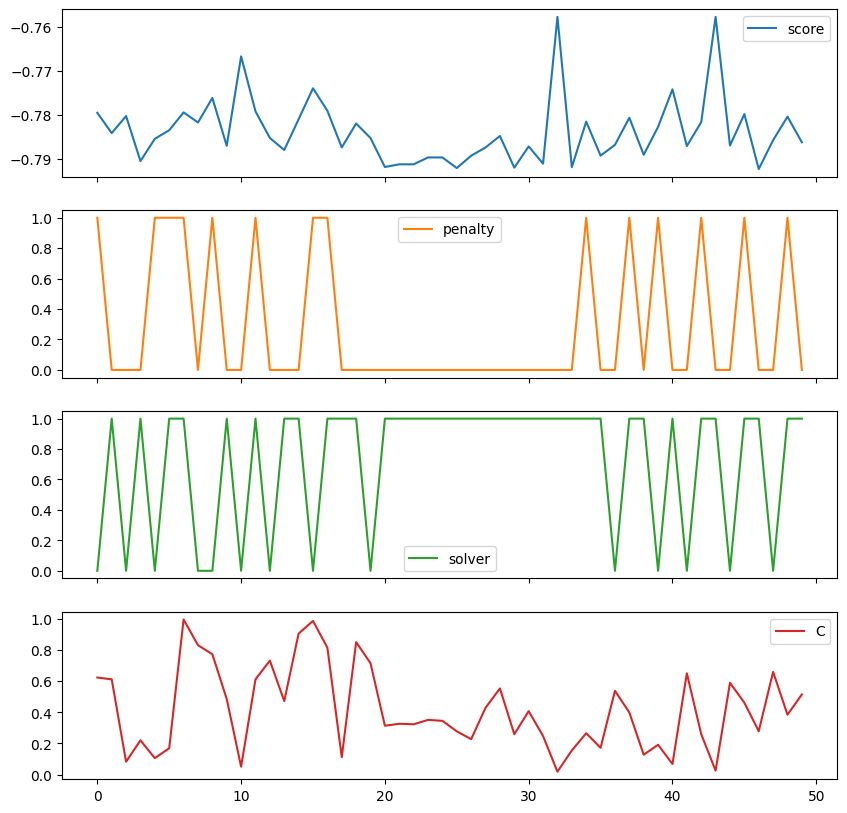

In [22]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'solver', 'C'])
tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [23]:
# расчитаем точность на тестовой выборке и полученных выше гиперпараметров

hyperopt_lr = linear_model.LogisticRegression(
    penalty=penalty_list[best['penalty']],
    solver=solver_list[best['solver']],
    C=best['C'],
    random_state=random_state,
    max_iter=max_iter,
)

hyperopt_lr.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(hyperopt_lr.score(X_test, y_test)))

y_test_pred = hyperopt_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79


### Выводы:
* метрика $F_1 = 0.78$ (или 0.79 при помощи кросс-валидации)
* библиотека hyperopt не показала ни улучшеные результаты по сравнению с базовыми методами, ни увеличение скорости работы. Возможно, это связано с ограничением в 50 итераций
* кросс-валидация помогла улучшить метрику (0.79) по сравнению с моделью с гипер-параметрами по-умолчанию (0.78)

### 4. Optuna

In [24]:
%%time

penalty_list = ['l1', 'l2']
solver_list = ['liblinear', 'saga']


def optuna_lr(trial):
    params = {
      'penalty': trial.suggest_categorical('penalty', penalty_list),
      'solver': trial.suggest_categorical('solver', solver_list),
      'C': trial.suggest_float('C', 0.01, 1),
    }

    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state,
        max_iter=max_iter,
    )

    # обучаем модель
    model.fit(X_train, y_train)

    score = metrics.f1_score(y_train, model.predict(X_train))

    return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=max_iter)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-10-24 18:30:11,382] A new study created in memory with name: LogisticRegression


[I 2023-10-24 18:30:13,304] Trial 0 finished with value: 0.8419480131461008 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.45127154796929275}. Best is trial 0 with value: 0.8419480131461008.
[I 2023-10-24 18:30:13,609] Trial 1 finished with value: 0.8867981790591806 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.6101102441907967}. Best is trial 1 with value: 0.8867981790591806.
[I 2023-10-24 18:30:15,467] Trial 2 finished with value: 0.8405970149253731 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.40673840375959097}. Best is trial 1 with value: 0.8867981790591806.
[I 2023-10-24 18:30:17,374] Trial 3 finished with value: 0.8418535127055305 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.43653692645576797}. Best is trial 1 with value: 0.8867981790591806.
[I 2023-10-24 18:30:17,612] Trial 4 finished with value: 0.8525179856115108 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.46997609234271}. Best is trial 1 with value:

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.9958172872371058}
f1_score на обучающем наборе: 0.89
CPU times: user 48.8 s, sys: 1min 36s, total: 2min 25s
Wall time: 31.7 s


In [25]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [26]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [27]:
# расчитаем точность на тестовой выборке и полученных выше гиперпараметров

optuna_lr = linear_model.LogisticRegression(
    **study.best_params,
    random_state=random_state,
    max_iter=max_iter,
)

optuna_lr.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(optuna_lr.score(X_test, y_test)))

y_test_pred = optuna_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


### Выводы
* метрика $F_1 = 0.78$
* метод Optuna не улучшил метрику по сравнению с моделью с гиперпараметрами по-умолчанию
* на графике "Optimization History Plot" видно, что после 12-й итерации метрика не улучшалась
* гиперпарамтр `C` вносит наибольший вклад в максимизацию метрики $F_1$

## Выводы по логистической регрессии
* базовые методы `GridSearchCV` и `RandomizedSearchCV` показали лучшую метрику $F_1 = 0.79$
* продвинуты методы оптимизации `Hyperopt` и `Optuna` не улучшили метрику по сравнению с моделью, у кототорой параметры выбраны по-умолчанию (кросс-валидация помогла методу `Hyperopt` достичь уровня базовых методов). Возможно, это связано с выбором гиперпараметров и ограничением на итерации
* для предоставленных данных наибольший вклад в максимизацию метрики $F_1$ вносит гиперпараметр `C`
* сделаю предположение, что модель логистической регрессии не является оптимальной для предоставленных данных, поэтому проверим как поведет себя модель случайного леса.

## Случайный лес

In [28]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.80


#### Промежуточный вывод
* модель случайно леса с параметрами по-умолчанию показывает лучшую метрику ($F_1 = 0.80$) чем модель логистической регрессии с базовыми или продвинутыми методами оптимизации

### 1. GridSearchCV

Попробуем применить следующие методы оптимизации гиперпараметров:

In [35]:
param_grid = {
    'n_estimators': list(range(80, 200, 30)),
    'min_samples_leaf': [5],
    'max_depth': list(np.linspace(20, 40, 10, dtype=int))
}

grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(
        random_state=random_state,
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1,
)

%time grid_search.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 1.7 s, sys: 134 ms, total: 1.83 s
Wall time: 22 s
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 22, 'min_samples_leaf': 5, 'n_estimators': 170}


### 2. RandomizedSearchCV

In [29]:
param_distributions = {
    'n_estimators': list(range(80, 200, 30)),
    'min_samples_leaf': [5],
    'max_depth': list(np.linspace(20, 40, 10, dtype=int))
}

random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions,
    cv=5,
    n_iter = max_iter,
    n_jobs = -1
)

%time random_search_forest.fit(X_train, y_train)
y_train_pred = random_search_forest.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 1.62 s, sys: 207 ms, total: 1.83 s
Wall time: 22.8 s
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 22}


### Выводы по базовым методам:
* методы `GridSearchCV` и `RandomizedSearchCV` не улучшили метрику $F_1$ по сравнению с моделью с параметрами по-умолчанию

### 3. Hyperopt

In [36]:
%%time

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth': hp.quniform('max_depth', 15, 26, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
}

def hyperopt_rf(params, X=X_train, y=y_train, cv=5, random_state=random_state):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf']),
    }
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)

    # обучение с помощью кросс-валидации
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_rf, # наша функция
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=max_iter, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [00:55<00:00,  1.11s/trial, best loss: -0.9917101627264354]
Наилучшие значения гиперпараметров {'max_depth': 26.0, 'min_samples_leaf': 2.0, 'n_estimators': 199.0}
CPU times: user 54.9 s, sys: 610 ms, total: 55.5 s
Wall time: 55.5 s


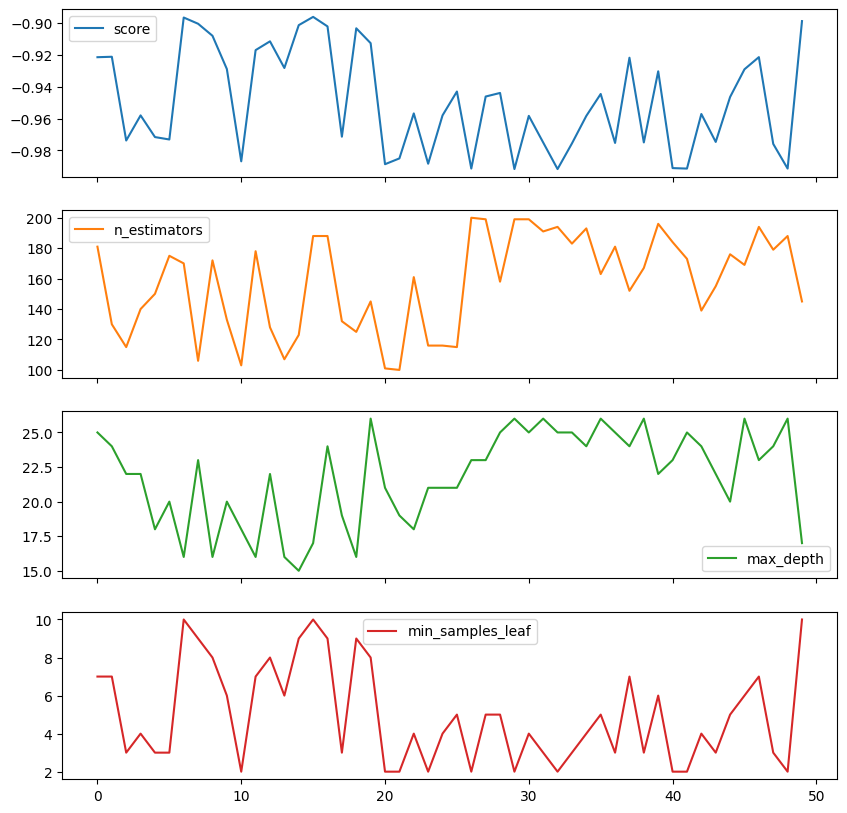

In [39]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_samples_leaf'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'n_estimators', 'max_depth', 'min_samples_leaf'])
tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [37]:
# расчитаем точность на тестовой выборке и полученных выше гиперпараметров

model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


### 4. Optuna

In [41]:
%%time

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state
  )

  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=max_iter)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-10-24 19:10:47,948] A new study created in memory with name: RandomForestClassifier
[I 2023-10-24 19:10:49,021] Trial 0 finished with value: 0.9083129584352079 and parameters: {'n_estimators': 154, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9083129584352079.
[I 2023-10-24 19:10:50,447] Trial 1 finished with value: 0.9746564885496183 and parameters: {'n_estimators': 193, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9746564885496183.
[I 2023-10-24 19:10:51,399] Trial 2 finished with value: 0.9035194174757283 and parameters: {'n_estimators': 157, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9746564885496183.
[I 2023-10-24 19:10:52,207] Trial 3 finished with value: 0.8968446601941747 and parameters: {'n_estimators': 137, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.9746564885496183.
[I 2023-10-24 19:10:53,186] Trial 4 finished with value: 0.9665450121654501 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 164, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99
CPU times: user 59.5 s, sys: 719 ms, total: 1min
Wall time: 1min


In [42]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


In [43]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [44]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

### Выводы
* метрика $F_1 = 0.81$
* метод Optuna показал наилучшую метрику
* на графике "Optimization History Plot" видно, что после 11-й итерации метрика не улучшалась
* гиперпарамтр `min_samples_leaf` вносит наибольший вклад в максимизацию метрики $F_1$

# Итоговые выводы
* модель случайного леса показывает лучшую метреки, по сравнению с моделью логистической регрессии 
* метод `Optuna` улучшил метрику $F_1 = 0.81$ для модели случайного леса
* не стоит тратить усилия по оптимизации, если модель с гиперпараметрами по-умолчанию показывает худшую метрику, чем другая модель